# Neurosymbolic Software Tutorial - NEAR Bouncing Ball

<a target="_blank" href="https://colab.research.google.com/github/kavigupta/neurosym-lib/blob/main/tutorial/bouncing_ball_exercise_solutions.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Instruction
- Navigating this notebook on Google Colab: There will be text blocks and code blocks throughout the notebook. The text blocks, such as this one, will contain instructions and questions for you to consider. The code blocks, such as the one below, will contain executible code. Sometimes you will have to modify the code blocks following the instructions in the text blocks. You can run the code block by either pressing control/cmd + enter or by clicking the arrow on left-hand side.
- Saving Work: If you wish to save your work in this .ipynb, we recommend downloading the compressed repository from GitHub, unzipping it, uploading it to Google Drive, and opening this notebook from within Google Drive.

## Notebook

In this notebook, you will construct a DSL to simulate a bouncing ball

In [1]:
%load_ext autoreload
%load_ext jupyter_black
%autoreload 2
%matplotlib inline

import logging
import os
import itertools
    
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import neurosym as ns
from neurosym.examples import near

pl = ns.import_pytorch_lightning()


In [2]:
torch.manual_seed(0)
np.random.seed(0)

## Data

We then load and plot some bouncing ball trajectories. Note that these trajectories are represented as a list `[x, y, vx, vy]`

In [3]:
dataset_factory = lambda train_seed: ns.DatasetWrapper(
    ns.DatasetFromNpy(
        f"bouncing_ball_exercise/data/bounce_example/train_ex_data.npy",
        f"bouncing_ball_exercise/data/bounce_example/train_ex_labels.npy",
        train_seed,
    ),
    ns.DatasetFromNpy(
        f"bouncing_ball_exercise/data/bounce_example/test_ex_data.npy",
        f"bouncing_ball_exercise/data/bounce_example/test_ex_labels.npy",
        None,
    ),
    batch_size=200,
)
datamodule = dataset_factory(42)

In [4]:
def plot_trajectory(trajectory, color, label=None):
    plt.scatter(
        trajectory[:, 0], trajectory[:, 1], marker="o", color=color, label=label
    )
    plt.plot(trajectory[:, 0], trajectory[:, 1], alpha=0.2, color=color)
    plt.xlim(-5, 10)
    plt.ylim(-5, 7)
    plt.grid(True)

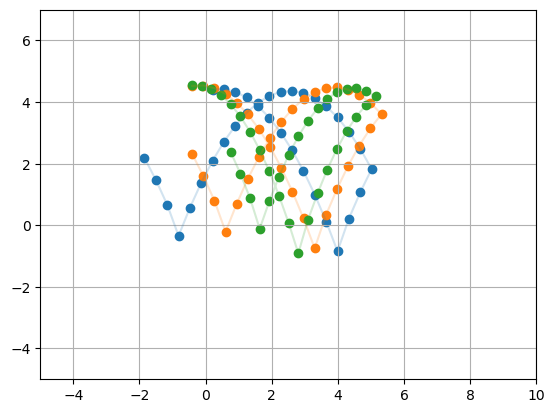

In [5]:
for i in range(3):
    plot_trajectory(datamodule.train.inputs[i], f"C{i}")

In [6]:
print("input[0] :", datamodule.train.inputs[i, 0])
print("output[0]:", datamodule.train.outputs[i, 0])

input[0] : [-0.40642968  4.5408607   2.9196808  -0.05576635]
output[0]: [-0.11446159  4.535284    2.9196808  -1.0357664 ]


## Exercise: DSL

Fill in the `bounce_dsl` to parameterize the space of functions that could represent the trajectories of bouncing balls.

In [7]:
L = 4


def bounce_dsl():
    dslf = ns.DSLFactory(L=L, max_overall_depth=5)
    # BEGIN SOLUTION "YOUR CODE HERE"
    ## DSL for the bounce example.
    dslf.typedef("fL", "{f, $L}")

    dslf.parameterized(
        "linear_bool",
        "() -> $fL -> {f, 1}",
        lambda lin: lin,
        dict(lin=lambda: nn.Linear(L, 1)),
    )
    dslf.parameterized(
        "linear", "() -> $fL -> $fL", lambda lin: lin, dict(lin=lambda: nn.Linear(L, L))
    )

    dslf.concrete(
        "ite",
        "(#a -> {f, 1}, #a -> #a, #a -> #a) -> #a -> #a",
        near.operations.ite_torch,
    )
    dslf.concrete(
        "map",
        "(#a -> #b) -> [#a] -> [#b]",
        lambda f: lambda x: near.operations.map_torch(f, x),
    )
    # END SOLUTION
    dslf.prune_to("[$fL] -> [$fL]")
    return dslf.finalize()


def predicate_dsl():
    dslf = ns.DSLFactory(L=L, max_overall_depth=5)
    dslf.typedef("fL", "{f, $L}")

    def add_projection(name, channel):
        dslf.parameterized(
            name,
            "$fL -> {f, 1}",
            lambda x, lin: lin(x[..., [channel]]),
            dict(lin=lambda: nn.Linear(1, 1)),
        )

    for channel, name in enumerate(["aff_x", "aff_y", "aff_vx", "aff_vy"]):
        add_projection(name, channel)
    dslf.lambdas()
    dslf.prune_to("$fL -> {f, 1}")
    return dslf.finalize()


def linear_dsl():
    assert L == 4
    dslf = ns.DSLFactory(L=L, max_overall_depth=5)
    dslf.typedef("fL", "{f, $L}")

    def add_projection(name, channel):
        dslf.parameterized(
            name,
            "$fL -> {f, 1}",
            lambda x, lin: lin(x[..., [channel]]),
            dict(lin=lambda: nn.Linear(1, 1)),
        )

    for channel, name in enumerate(["aff_x", "aff_y", "aff_vx", "aff_vy"]):
        add_projection(name, channel)
    dslf.concrete(
        "vec4",
        "({f, 1}, {f, 1}, {f, 1}, {f, 1}) -> $fL",
        lambda a, b, c, d: torch.cat([a, b, c, d], axis=-1),
    )
    dslf.concrete(
        "+",
        "({f, 1}, {f, 1}) -> {f, 1}",
        lambda a, b: a + b,
    )
    dslf.lambdas()
    dslf.prune_to("$fL -> $fL")
    return dslf.finalize()

In [8]:
dsl = bounce_dsl()
dsl_p = predicate_dsl()
dsl_l = linear_dsl()

### DSL Printout

See your DSL printed below, and ensure it is what you would expect

In [9]:
print(dsl.render())

            ite :: (#a -> {f, 1}, #a -> #a, #a -> #a) -> #a -> #a
            map :: (#a -> #b) -> [#a] -> [#b]
linear_bool[lin] :: () -> {f, 4} -> {f, 1}
    linear[lin] :: () -> {f, 4} -> {f, 4}


In [10]:
print(dsl_p.render())

     aff_x[lin] :: {f, 4} -> {f, 1}
     aff_y[lin] :: {f, 4} -> {f, 1}
    aff_vx[lin] :: {f, 4} -> {f, 1}
    aff_vy[lin] :: {f, 4} -> {f, 1}
            lam :: L<#body|{f, 4}> -> {f, 4} -> #body
           $0_0 :: V<{f, 4}@0>


### Setting up Neural DSL

In [11]:
input_dim, output_dim = 4, 4
max_depth = 16

### Run NEAR

In [12]:
t = ns.TypeDefiner(L=input_dim, O=output_dim)
t.typedef("fL", "{f, $L}")

In [13]:
# filler = near.GenericMLPRNNNeuralHoleFiller(hidden_size=10)
# g = near.heirarchical_near_graph(
#     high_level_dsl=dsl,
#     symbol="linear",
#     refined_dsl=dsl_l,
#     typ=t("([{f, $L}]) -> [{f, $O}]"),
#     # is_goal=lambda x: True,
#     validation_cost_creator=lambda dsl, embedding: near.ValidationCost(
#         trainer_cfg=near.NEARTrainerConfig(
#             lr=0.1,
#             n_epochs=100,
#             accelerator="cpu",
#             loss_callback=nn.functional.mse_loss,
#         ),
#         neural_dsl=near.NeuralDSL.from_dsl(dsl, filler),
#         datamodule=datamodule,
#         progress_by_epoch=True,
#         embedding=embedding,
#         structural_cost_weight=0.5,
#     ),
#     neural_hole_filler=filler,
#     validation_epochs=4000,
# )
filler = near.GenericMLPRNNNeuralHoleFiller(hidden_size=10)
g = near.heirarchical_near_graph(
    high_level_dsl=dsl,
    symbol="linear_bool",
    refined_dsl=dsl_p,
    typ=t("([{f, $L}]) -> [{f, $O}]"),
    # is_goal=lambda x: True,
    validation_cost_creator=lambda dsl, embedding: near.ValidationCost(
        trainer_cfg=near.NEARTrainerConfig(
            lr=0.1,
            n_epochs=100,
            accelerator="cpu",
            loss_callback=nn.functional.mse_loss,
        ),
        neural_dsl=near.NeuralDSL.from_dsl(dsl, filler),
        datamodule=datamodule,
        progress_by_epoch=True,
        embedding=embedding,
        structural_cost_weight=0.5,
    ),
    neural_hole_filler=filler,
    validation_epochs=4000,
)

In [14]:
dsl_merged = dsl.add_productions(*dsl_p.productions)

In [19]:
best_programs = list(
    itertools.islice(
        ns.search.bounded_astar(g, max_depth=1000, max_iterations=10000), 5
    )
)

Training ??::<[{f, 4}] -> [{f, 4}]>
Training (ite ??::<[{f, 4}] -> {f, 1}> ??::<[{f, 4}] -> [{f, 4}]> ??::<[{f, 4}] -> [{f, 4}]>)
Training (map ??::<{f, 4} -> {f, 4}>)
Training (map (ite ??::<{f, 4} -> {f, 1}> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>))
Training (map (linear))
Training (map (ite (linear_bool) ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>))
Training (map (ite (linear_bool) (ite ??::<{f, 4} -> {f, 1}> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>) ??::<{f, 4} -> {f, 4}>))
Training (map (ite (linear_bool) (linear) ??::<{f, 4} -> {f, 4}>))
Training (map (ite (linear_bool) (linear) (ite ??::<{f, 4} -> {f, 1}> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>)))
Training (map (ite (linear_bool) (linear) (linear)))
Validating (map (ite (linear_bool) (linear) (linear)))
Training (map (ite (linear_bool) (linear) (linear)))
Training ??::<{f, 4} -> {f, 1}>
Training (lam ??::<{f, 1}|0={f, 4}>)
Training (lam (aff_x ??::<{f, 4}|0={f, 4}>))
Training (lam (aff_y ??::<{f, 4}|0={f, 4}>)

### Top 3 Programs

Now, we show the top 3 programs

In [20]:
for prog in best_programs:
    print(ns.render_s_expression(prog.uninitialize()))

(map (ite (lam (aff_y ($0_0))) (linear) (linear)))
(map (ite (lam (aff_y ($0_0))) (linear) (ite (lam (aff_y ($0_0))) (linear) (linear))))
(map (ite (lam (aff_vy ($0_0))) (linear) (ite (lam (aff_y ($0_0))) (linear) (linear))))
(map (ite (lam (aff_vx ($0_0))) (linear) (ite (lam (aff_y ($0_0))) (linear) (linear))))
(map (ite (lam (aff_x ($0_0))) (linear) (ite (lam (aff_y ($0_0))) (linear) (linear))))


## Plotting Trajectories

We plot all the trajectories

In [21]:
def program_to_trajectory(dsl, best_program):
    T = 100
    path = np.zeros((T, 4))
    X = torch.tensor(
        np.array([0.21413583, 4.4062634, 3.4344807, 0.12440437]), dtype=torch.float32
    )
    for t in range(T):
        path[t, :] = X.detach().numpy()
        Y = dsl.compute(best_program)(X.unsqueeze(0)).squeeze(0)
        X = Y
    return path


def plot_programs(dsl, best_programs):
    plt.figure(figsize=(8, 8))

    plot_trajectory(datamodule.train.inputs[0], "black")
    for i, (prog) in enumerate(best_programs):
        plot_trajectory(
            program_to_trajectory(dsl, prog),
            f"C{i}",
            label=ns.render_s_expression(prog.uninitialize()).replace("$", r"\$"),
        )

    plt.title("Bouncing ball (ground truth in black)")
    plt.legend()
    plt.show()

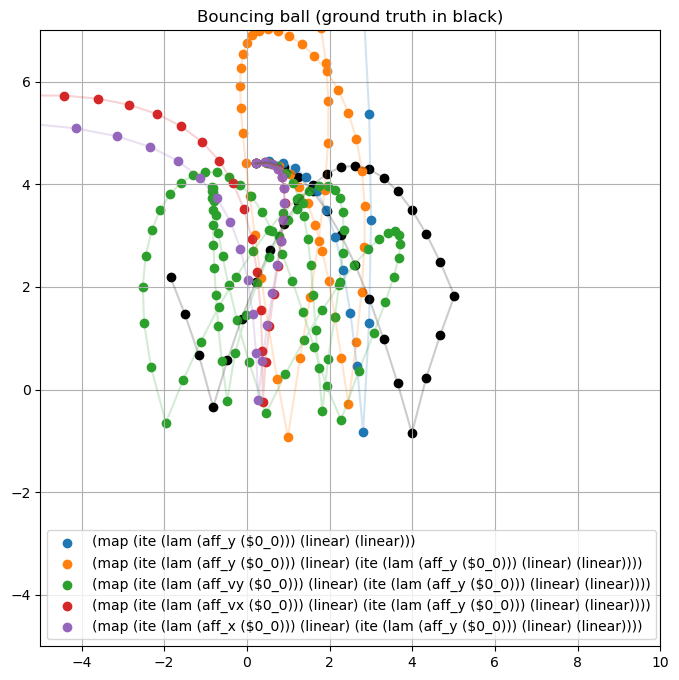

In [22]:
plot_programs(dsl_merged, best_programs)